# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
import os
import json
from PIL import Image
! pip install datasets
! pip install docai-py
! pip install transformers
from datasets import Dataset
from datasets.features import ClassLabel
from docai.annotations import get_ner_tags_for_model
from transformers import AutoProcessor
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
import torch
import cv2

# PDF to JPG

In [ ]:
! pip install pypdfium2
import pypdfium2 as pdfium

In [ ]:
directory = r"/content/gdrive/MyDrive/Capstone/Thurston-2020/"
i = 0
flag = False
for root1, dirs1, files1 in os.walk(directory):
    for dir1 in dirs1:
        print(dir1)
        if i % 10 == 0:
            for root2, dirs2, files2 in os.walk(directory + "/" + dir1 + "/"):
                for file2 in files2:
                    # Load a document
                    print(file2)
                    try:
                        pdf = pdfium.PdfDocument(directory + "/" + dir1 + "/" + file2)
                    except:
                        print("Failed file:", file2)
                        continue
                    
                    # render multiple pages concurrently (in this case: all)
                    page_indices = [i for i in range(len(pdf))]
                    renderer = pdf.render(
                        pdfium.PdfBitmap.to_pil,
                        page_indices = page_indices,
                    )

                    for image, index in zip(renderer, page_indices):
                        image.save("/content/gdrive/MyDrive/Capstone/2020_jpg/" + file2[:-4] + "_%02d.jpg" % index)
        i += 1
        if i == 201:
            flag = True
            break
    if flag:
        break

# JPG to JSON

In [ ]:
! sudo apt install tesseract-ocr
! pip install pytesseract
import pytesseract
from pytesseract import Output
! which tesseract

In [ ]:
def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

def create_bbox(top, left, height, width, img):
    bbox = []
    for i in range(len(top)):
        bottom = top[i] + height[i]
        right = left[i] + width[i]
        w, h = img.size
        bbox.append(([left[i], top[i], right, bottom], normalize_bbox([left[i], top[i], right, bottom], w, h)))
    return bbox

In [ ]:
directory = r"/content/gdrive/MyDrive/Capstone/2020_jpg/"

for root, dirs, files in os.walk(directory):
    for file in files:
        print(file)
        img = cv2.imread(directory + "/" + file)

        d = pytesseract.image_to_data(img, output_type=Output.DICT)
        n_boxes = len(d['level'])
        for i in range(n_boxes):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        image = Image.open(directory + "/" + file).convert("RGB")
        words = d['text']
        bbox = create_bbox(d['top'], d['left'], d['height'], d['width'], image)
        labels = []
        print(words)
        for i in range(len(words)):
            if not words[i] or words[i] == " ":
                labels.append('5')
                continue
            label = input('Num: ' + str(i) + ' -- Text: ' + words[i] + ': ')
            if not label:
                label = '5'
            labels.append(label)
        dct = {
            'id': file[:-4],
            'tokens': words,
            'bbox_not_normal': [x[0] for x in bbox],
            'bboxes': [x[1] for x in bbox],
            'ner_tags': labels
        }
        json_object = json.dumps(dct, indent=4)
        with open('/content/gdrive/MyDrive/Capstone/2020_json/' + file[:-4] + ".json", "w") as outfile:
            outfile.write(json_object)
print("JSON created successfully!")

# JSON prep

In [ ]:
directory = r"/content/gdrive/MyDrive/Capstone/2020_json/"
big_list = []
label_id_to_label = {
    "1": "Judgement_Amount",
    "2": "Principal_Amount",
    "3": "Defendant_Name",
    "4": "Defendant_Address",
    "5": "O"
}
## Assuming JSON comes in number format (1-5)
for root, dirs, files in os.walk(directory):
    for file in files:
        print(file)
        with open(directory + '/' + file) as f:
            data = json.load(f)
        data['image'] = Image.open(directory[:-5] + 'jpg/' + file[:-4] + 'jpg')
        # data['ner_tags'] = ["B-" + x if x != "5" else 'O' for x in data['ner_tags']]
        # BIO tagging
        bio_labels = []
        temp = "O"
        for label in data['ner_tags']:
          label = label_id_to_label[label]
          if label == "O":
            bio_labels.append(label)
            temp = "O"
          elif temp == label:
            bio_labels.append("I-" + label)
          else:
            bio_labels.append("B-" + label)
            temp = label
        data['ner_tags'] = bio_labels
        del data['bbox_not_normal']
        big_list.append(data)
dataset = Dataset.from_list(big_list)

# Layout LM

In [ ]:
label_list = []
for label in label_id_to_label.values():
  if label == "O":
    label_list.append("O")
  else:
    label_list.append("B-" + label)
    label_list.append("I-" + label)
class_label = ClassLabel(names=label_list)
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}
column_names = dataset.column_names

# Split dataset into train/test
dataset = dataset.train_test_split(test_size=0.1)

In [ ]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

def convert_ner_tags_to_id(ner_tags):
    return [label2id[ner_tag] for ner_tag in ner_tags]

# This function is used to put the Dataset in its final format for training LayoutLM
def prepare_dataset(annotations):
    images = annotations['image']
    words = annotations['tokens']
    boxes = annotations['bboxes']
    # Map over labels and convert to numeric id for each ner_tag
    ner_tags = [convert_ner_tags_to_id(ner_tags) for ner_tags in annotations['ner_tags']]

    encoding = processor(images, words, boxes=boxes, word_labels=ner_tags, truncation=True, padding="max_length")

    return encoding

In [ ]:
# Define features for use training the model 
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)), # up from 512
    'labels': Sequence(feature=Value(dtype='int64')),
})

# Prepare our train & eval dataset
train_dataset = dataset["train"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

In [ ]:
from docai.training import generate_layoutlm_compute_eval_metric_fn

# Use this utility from the docai SDK to create a function that can
# be used to calculate the evaluation metrics while training
compute_eval_metrics = generate_layoutlm_compute_eval_metric_fn(
    ner_labels=label_list,
    metric_name="seqeval",
    return_entity_level_metrics=False
)

In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import LayoutLMv3ForTokenClassification
from transformers.data.data_collator import default_data_collator

MODEL_NAME = 'us_dl_model'

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    id2label=id2label,
    label2id=label2id)

training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    max_steps=1000,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-5,
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy")

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_eval_metrics,
)

# Train !

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 51
  Num Epochs = 39
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 125333897
/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:810: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.084407,0.400000,0.153846,0.222222,0.983488
200,No log,0.039773,0.454545,0.384615,0.416667,0.989680
300,No log,0.044229,0.727273,0.615385,0.666667,0.992776
400,No log,0.050312,0.666667,0.615385,0.640000,0.991744
500,0.061700,0.047696,0.666667,0.615385,0.640000,0.991744
600,0.061700,0.046467,0.461538,0.461538,0.461538,0.988648
700,0.061700,0.047576,0.545455,0.461538,0.500000,0.990712
800,0.061700,0.046906,0.416667,0.384615,0.400000,0.988648
900,0.061700,0.047220,0.545455,0.461538,0.500000,0.990712
1000,0.002200,0.047226,0.545455,0.461538,0.500000,0.990712


***** Running Evaluation *****
  Num examples = 6
  Batch size = 2
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 6
  Batch size = 2
***** Running Evaluation *****
  Num examples = 6
  Batch size = 2
***** Running Evaluation *****
  Num examples = 6
  Batch size = 2
***** Running Evaluation *****
  Num examples = 6
  Batch size = 2
Saving model checkpoint to us_dl_model/checkpoint-500
Configuration saved in us_dl_model/checkpoint-500/config.json
Model weights saved in us_dl_model/checkpoint-500/pytorch_model.bin
Image processor saved in us_dl_model/checkpoint-500/preprocessor_config.json
tokenizer config file saved in us_dl_model/checkpoint-500/tokenizer_config.json
Special tokens file saved in

TrainOutput(global_step=1000, training_loss=0.03193097817897796, metrics={'train_runtime': 533.8894, 'train_samples_per_second': 3.746, 'train_steps_per_second': 1.873, 'total_flos': 517202953353216.0, 'train_loss': 0.03193097817897796, 'epoch': 38.46})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 6
  Batch size = 2
/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:810: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.04769595339894295,
 'eval_precision': 0.6666666666666666,
 'eval_recall': 0.6153846153846154,
 'eval_f1': 0.64,
 'eval_accuracy': 0.9917440660474717,
 'eval_runtime': 0.8026,
 'eval_samples_per_second': 7.476,
 'eval_steps_per_second': 3.738,
 'epoch': 38.46}

# Results

In [ ]:
from PIL import ImageDraw, ImageFont
from transformers import AutoModelForTokenClassification

font = ImageFont.load_default()

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def iob_to_label(label):
    label = label[2:]
    if not label:
        return 'other'
    return label

def draw_boxes_on_img(
    preds_or_labels, 
    boxes,
    draw,
    image, 
    unnormalize = False
):
    label_color_lookup = {
        'judgement_amount': "green",
        "principal_amount": "blue",
        "defendant_name": "red",
        "defendant_address": "orange",
        "other": "yellow"
    }
  
    for pred_or_label, box in zip(preds_or_labels, boxes):
        label = iob_to_label(pred_or_label).lower()

        if label == 'other':
            continue
        else:
            if unnormalize:
                box = unnormalize_box(box, width, height)
        
            color = label_color_lookup[label]
            draw.rectangle(box, outline=color)
            draw.text((box[0] + 10, box[1] - 10), text=label, fill=color, font=font)

B-Defendant_Name
I-Defendant_Name
I-Defendant_Name
B-Defendant_Name
I-Defendant_Name
B-Defendant_Name
I-Defendant_Name
I-Defendant_Name
B-Judgement_Amount


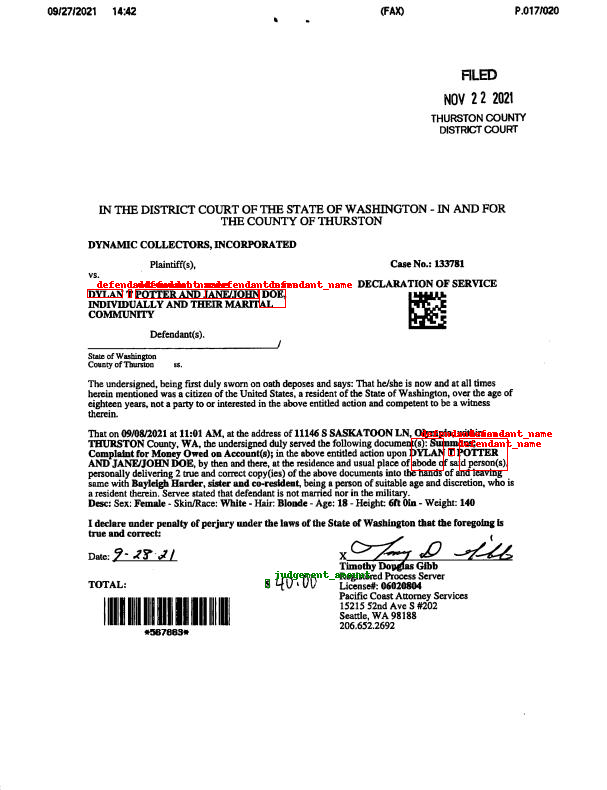

B-Defendant_Name
I-Defendant_Name
I-Defendant_Name


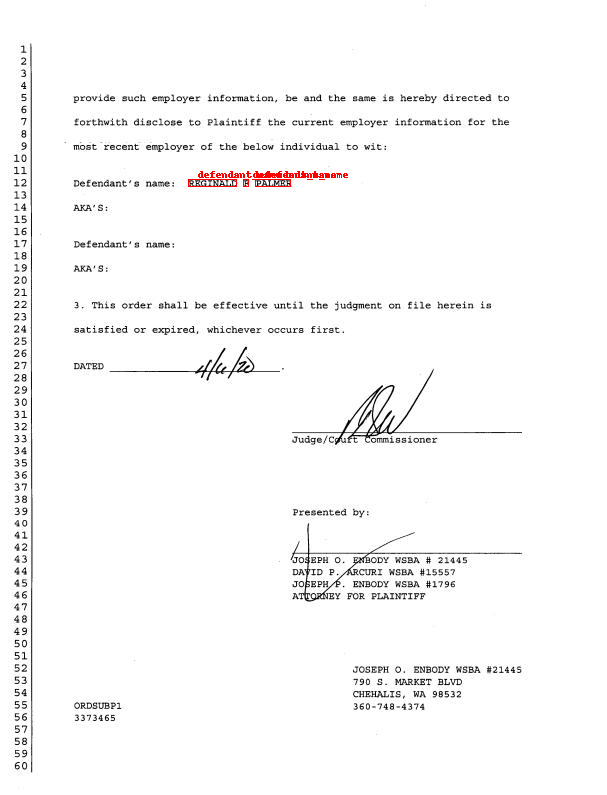

B-Defendant_Name
I-Defendant_Name
I-Defendant_Name
B-Defendant_Name
I-Defendant_Name


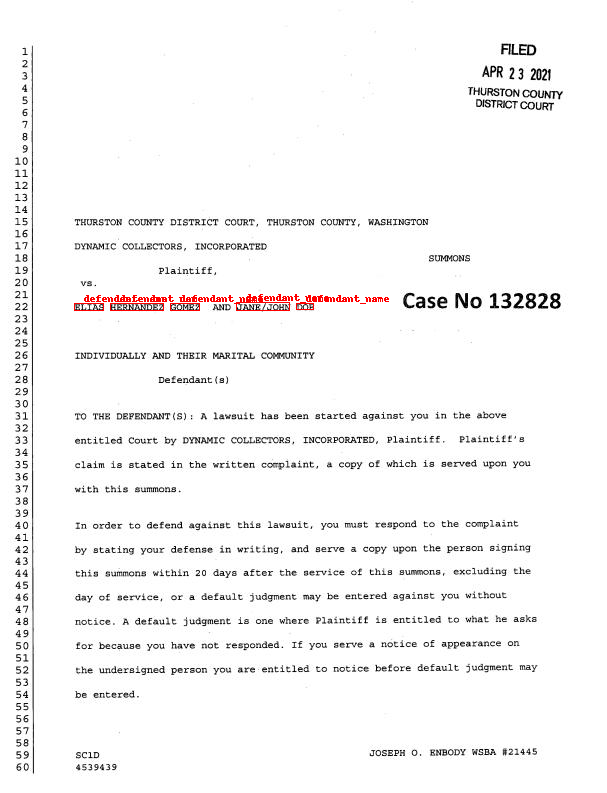

B-Principal_Amount


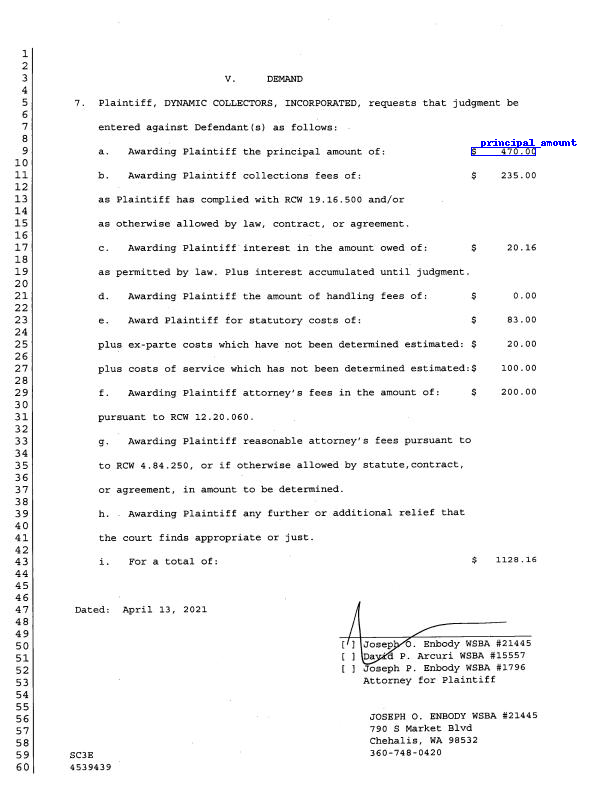

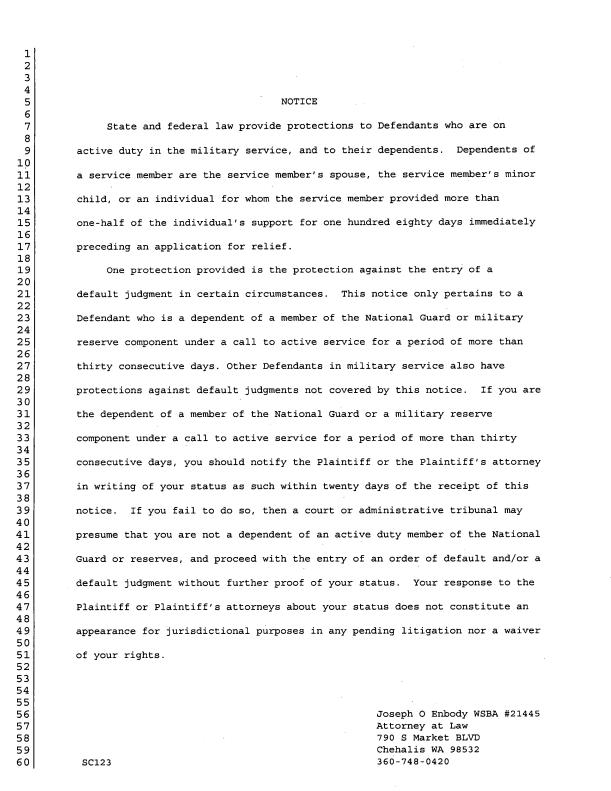

B-Principal_Amount
B-Principal_Amount
B-Principal_Amount
B-Judgement_Amount


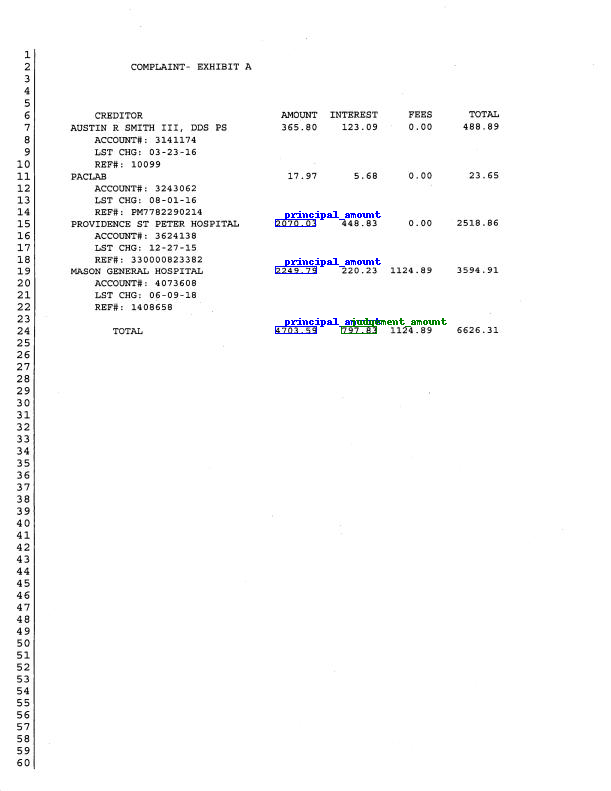

In [ ]:
# num = 0 # use for calculating non-O tokens
# cnt = 0
for example in dataset['test']:
    image = example["image"]
    words = example["tokens"]
    boxes = example["bboxes"]
    labels = convert_ner_tags_to_id(example["ner_tags"])
    labels_true = labels

    encoding = processor(image, words, boxes=boxes, word_labels=labels, return_tensors="pt")

    if torch.cuda.is_available():
      encoding.to("cuda")
      model.to("cuda")

    with torch.no_grad():
        outputs = model(**encoding)

    logits = outputs.logits
    predictions = logits.argmax(-1).squeeze().tolist()
    labels = encoding.labels.squeeze().tolist()

    token_boxes = encoding.bbox.squeeze().tolist()
    width, height = image.size

    true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
    true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
    true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]
    # for i in range(len(true_labels)):
    #     if true_labels[i] != "O":
    #         cnt += 1
    #         if true_labels[i] == true_predictions[i]:
    #             num += 1
    image = image.convert("RGB")
    draw = ImageDraw.Draw(image)

    draw_boxes_on_img(true_predictions, true_boxes, draw, image)
    display(image)
    image.save(r"/content/gdrive/MyDrive/Capstone/2020_test/" + example['id'] + ".jpg")
# print(num, cnt)

In [ ]:
num = 0 # use for calculating non-O tokens
cnt = 0

for example in dataset['train']:
    image = example["image"]
    words = example["tokens"]
    boxes = example["bboxes"]
    labels = convert_ner_tags_to_id(example["ner_tags"])

    encoding = processor(image, words, boxes=boxes, word_labels=labels, return_tensors="pt")

    if torch.cuda.is_available():
      encoding.to("cuda")
      model.to("cuda")

    with torch.no_grad():
        outputs = model(**encoding)

    logits = outputs.logits
    predictions = logits.argmax(-1).squeeze().tolist()
    labels = encoding.labels.squeeze().tolist()

    token_boxes = encoding.bbox.squeeze().tolist()
    width, height = image.size

    true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
    true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
    true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]
    for i in range(len(true_labels)):
        if true_labels[i] != "O":
            cnt += 1
            if true_labels[i] == true_predictions[i]:
                num += 1
    image = image.convert("RGB")
    draw = ImageDraw.Draw(image)

    draw_boxes_on_img(true_predictions, true_boxes, draw, image)
    # display(image)
    image.save(r"/content/gdrive/MyDrive/Capstone/2020_train/" + example['id'] + ".jpg")
print(num, cnt)